In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt
from modopt.opt.proximity import SparseThreshold
from modopt.opt.linear import Identity
from mri.operators import FFT, WaveletN
from mri.operators.utils import convert_mask_to_locations
from mri.reconstructors import SingleChannelReconstructor
import numpy as np
from pysap.base.utils import flatten, unflatten
import pywt
from tqdm.notebook import tqdm

from fastmri_recon.data.fastmri_sequences import Masked2DSequence
from fastmri_recon.helpers.utils import crop_center
from fastmri_recon.helpers.evaluate import psnr, ssim
from fastmri_recon.helpers.evaluate import METRIC_FUNCS, Metrics

/volatile/home/Zaccharie/workspace/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/volatile/home/Zaccharie/workspace/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.3     installed
numpy          : >=1.16.4  - required | 1.17.4    installed
matplotlib     : >=3.0.0   - required | 3.1.2     installed
astropy        : >=3.0.0   - required | 4.0       installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.2     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# paths
train_path = '/media/Zaccharie/UHRes/singlecoil_train/singlecoil_train/'
val_path = '/media/Zaccharie/UHRes/singlecoil_val/'
test_path = '/media/Zaccharie/UHRes/singlecoil_test/'

n_volumes_train = 973
n_volumes_val = 199

In [4]:
# generators
# CORPDFS_FBK CORPD_FBK None
AF = 4
train_gen = Masked2DSequence(train_path, af=AF, inner_slices=1, contrast='CORPDFS_FBK')
val_gen = Masked2DSequence(val_path, af=AF, contrast='CORPDFS_FBK')

In [5]:
def reconstruct_image(kspace, mask, max_iter=200, mu=0.1):
    kspace_squeeze = np.squeeze(kspace)
    mask = np.squeeze(mask)
    k_shape = kspace_squeeze.shape
    kspace_loc = convert_mask_to_locations(mask)
    fourier_op = FFT(samples=kspace_loc, shape=k_shape)
    linear_op = WaveletN(wavelet_name="sym8", nb_scales=4)
#     _ = linear_op.op(np.ones_like(kspace_squeeze))
#     coarse_mask, _ = flatten([np.ones(linear_op.coeffs_shape[0])] + [np.zeros(coef_shape) for coef_shape in linear_op.coeffs_shape[1:]])
    regularizer_op = SparseThreshold(Identity(), mu, thresh_type="soft")
    reconstructor = SingleChannelReconstructor(
        fourier_op=fourier_op,
        linear_op=linear_op,
        regularizer_op=regularizer_op,
        gradient_formulation='synthesis',
        verbose=0,
    )
    x_final, costs, metrics = reconstructor.reconstruct(
        kspace_data=kspace_squeeze,
        optimization_alg='fista',
        num_iterations=max_iter,
        restart_strategy='greedy',
        xi_restart=0.96, 
        s_greedy=1.3,
        metric_call_period=None,
        progress=False,
        cost_op_kwargs={'cost_interval': None},
    )
    image_rec_fs = crop_center(np.abs(x_final), 320)
    return image_rec_fs

def reconstruct_zero(kspace, mask):
    kspace_squeeze = np.squeeze(kspace)
    mask = np.squeeze(mask)
    k_shape = kspace_squeeze.shape
    kspace_loc = convert_mask_to_locations(mask)
    fourier_op = FFT(samples=kspace_loc, shape=k_shape)
    x = fourier_op.adj_op(kspace_squeeze)
    image_rec_fs = crop_center(np.abs(x), 320)
    return image_rec_fs

In [6]:
def metrics_for_args(sub_prop=0.2, **rec_kwargs):
    metrics = Metrics(METRIC_FUNCS)
    sampled_ids = np.random.randint(high=n_volumes_train//2-1, low=0, size=int(sub_prop * n_volumes_train//2))
    pred_and_gt = [
        (reconstruct_image(*train_gen[sampled_id][0], **rec_kwargs), train_gen[sampled_id][1])
        for sampled_id in tqdm(sampled_ids, desc='K-spaces')
    ]

    for im_recos, images in tqdm(pred_and_gt, desc='Stats'):
        metrics.push(images[..., 0], im_recos[None, ...])
    return metrics

In [7]:
def metrics_zero(sub_prop=0.2):
    metrics = Metrics(METRIC_FUNCS)
    sampled_ids = np.random.randint(high=n_volumes_train//2-1, low=0, size=int(sub_prop * n_volumes_train//2))
    pred_and_gt = [
        (reconstruct_zero(*train_gen[sampled_id][0]), train_gen[sampled_id][1])
        for sampled_id in tqdm(sampled_ids, desc='K-spaces')
    ]

    for im_recos, images in tqdm(pred_and_gt, desc='Stats for zero'):
        metrics.push(images[..., 0], im_recos[None, ...])
    return metrics

In [8]:
def psnr_gain(sub_prop=0.2, **rec_kwargs):
    psnr_gains = []
    sampled_ids = np.random.randint(high=n_volumes_train//2-1, low=0, size=int(sub_prop * n_volumes_train//2))
    for sampled_id in tqdm(sampled_ids, desc='K-spaces'):
        kspace_mask, orig_image = train_gen[sampled_id]
        pred = reconstruct_image(*kspace_mask, **rec_kwargs)
        z_pred = reconstruct_zero(*kspace_mask)
        _psnr = psnr(np.squeeze(orig_image), np.squeeze(pred))
        z_psnr = psnr(np.squeeze(orig_image), np.squeeze(z_pred))
        _psnr_gain = _psnr - z_psnr
        psnr_gains.append(_psnr_gain)
    return np.mean(psnr_gains), np.std(psnr_gains)

In [9]:
mz = metrics_zero(sub_prop=1).metrics['PSNR']
mz.mean(), mz.stddev()

/volatile/home/Zaccharie/workspace/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/fastmri_recon/helpers/evaluate.py:24: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  return compare_psnr(gt, pred, data_range=gt.max() - gt.min())
/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/fastmri_recon/helpers/evaluate.py:30: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max() - gt.min()


(24.381956473547696, 1.6356807567511964)

<IPython.core.display.Javascript object>


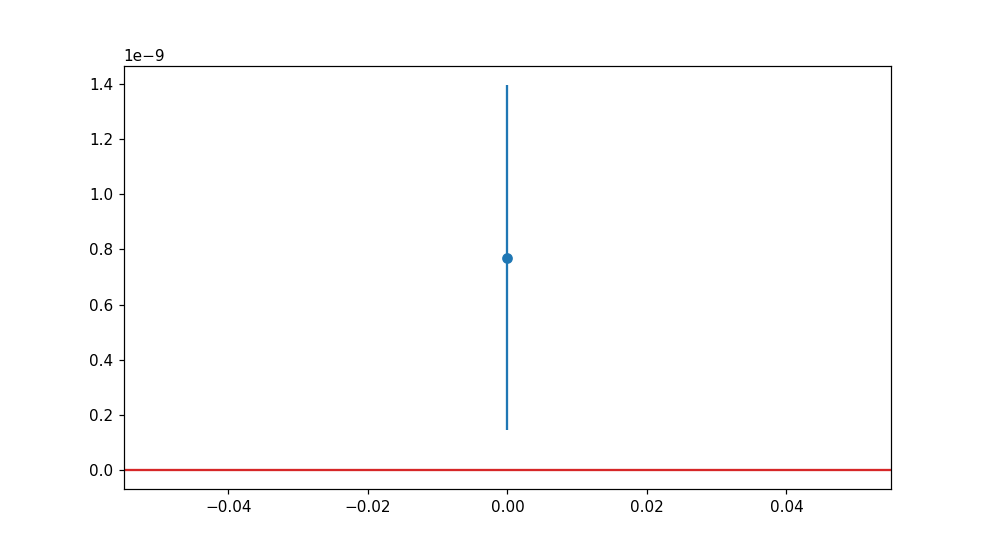

In [10]:
# sanity check
plt.figure()
psnr_gains = psnr_gain(sub_prop=0.01, mu=0)
plt.errorbar(
    0, 
    psnr_gains[0], 
    psnr_gains[1],
    linestyle='None', 
    marker='o',
)
plt.axhline(0, color='C3')
# plt.xscale('log')

In [11]:
mus_to_test = np.logspace(-12, -3, 9)

In [12]:
%%time
metrics = []
for mu in tqdm(mus_to_test, desc='mus'):
    psnr_gains = psnr_gain(sub_prop=0.003, mu=mu)
    metrics.append(psnr_gains)



CPU times: user 1h 10min 46s, sys: 1h 25min 18s, total: 2h 36min 4s
Wall time: 5min 11s


<IPython.core.display.Javascript object>


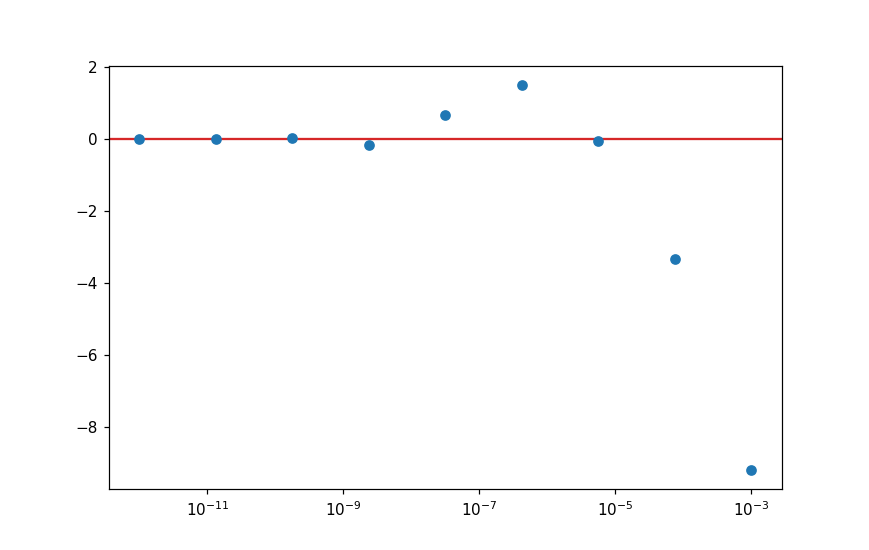

In [13]:
plt.figure()
plt.errorbar(
    mus_to_test, 
    [psnr_gains[0] for psnr_gains in metrics], 
    [psnr_gains[1] for psnr_gains in metrics], 
    linestyle='None', 
    marker='o',
)
plt.axhline(0, color='C3')
plt.xscale('log')

In [14]:
mus_to_test = np.logspace(-8, -5, 7)

In [ ]:
%%time
metrics = []
for mu in tqdm(mus_to_test, desc='mus'):
    psnr_gains = psnr_gain(sub_prop=0.05, mu=mu)
    metrics.append(psnr_gains)

/volatile/home/Zaccharie/workspace/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1
/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/fastmri_recon/helpers/evaluate.py:24: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  return compare_psnr(gt, pred, data_range=gt.max() - gt.min())


<IPython.core.display.Javascript object>


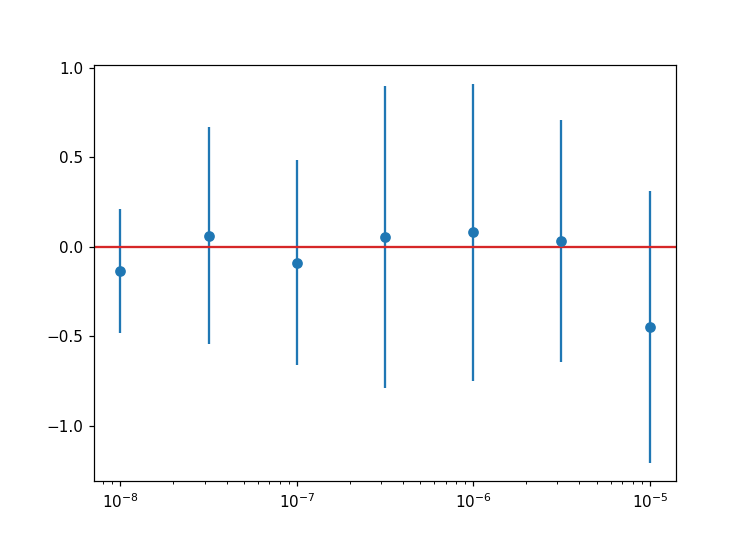

In [20]:
plt.figure()
plt.errorbar(
    mus_to_test, 
    [psnr_gains[0] for psnr_gains in metrics], 
    [psnr_gains[1] for psnr_gains in metrics], 
    linestyle='None', 
    marker='o',
)
plt.axhline(0, color='C3')
plt.xscale('log')

In [54]:
mus_to_test = np.logspace(-6.5, -5.5, 7)

In [55]:
%%time
metrics = []
for mu in tqdm(mus_to_test, desc='mus'):
    psnr_gains = psnr_gain(sub_prop=0.1, mu=mu)
    metrics.append(psnr_gains)

/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/fastmri_recon/data/data_utils.py:18: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(filename) as h5_obj:
/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/venv/lib/python3.6/site-packages/mri/reconstruct/utils.py:74: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.0999999999999774
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738780> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.129166774908001
 - converged:  True
Done.
Execution time:  1604.404189000008  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.0999999999999854
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738470> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.418936831273035
 - converged:  True
Done.
Execution time:  1556.348484000002  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.1000000000000307
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738358> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -5.175782095709387
 - converged:  True
Done.
Execution time:  1600.4624179999955  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.1000000000000216
 - data:  (640, 338)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738be0> - 4
 - max iterations:  200
 - image variable shape:  (640, 338)
 - alpha variable shape:  (216880,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:48 Time:  0:00:48


 - final iteration number:  200
 - final log10 cost value:  -6.12450223235385
 - converged:  True
Done.
Execution time:  1610.3389529999986  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.1000000000000878
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41578ec88> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.4349043533584265
 - converged:  True
Done.
Execution time:  1644.1018040000054  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.1000000000000303
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41578ebe0> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -6.5467727080736875
 - converged:  True
Done.
Execution time:  1670.9342869999964  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.099999999999974
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738be0> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.276227700315011
 - converged:  True
Done.
Execution time:  1680.9568870000076  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.100000000000089
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41578e630> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.364504777813146
 - converged:  True
Done.
Execution time:  1642.4891770000104  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.099999999999977
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41578ed30> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -6.471197495286625
 - converged:  True
Done.
Execution time:  1679.9251610000065  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.100000000000085
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41578e860> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.3912519208579806
 - converged:  True
Done.
Execution time:  1644.2491330000048  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.1000000000000845
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415760ef0> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.1479384899800475
 - converged:  True
Done.
Execution time:  1677.750469000006  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.1000000000000694
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415760320> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -6.289961427742488
 - converged:  True
Done.
Execution time:  1671.3306490000105  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.1000000000000292
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738f28> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.4303912926666955
 - converged:  True
Done.
Execution time:  1680.4874300000083  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.1000000000000734
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415760c18> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.373431815844556
 - converged:  True
Done.
Execution time:  1644.9911970000103  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.099999999999977
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157602e8> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.45388146050302
 - converged:  True
Done.
Execution time:  1652.7812750000012  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.1000000000000822
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41578e630> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:53 Time:  0:00:53


 - final iteration number:  200
 - final log10 cost value:  -6.359165348174548
 - converged:  True
Done.
Execution time:  1605.553031000003  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.10000000000007
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41578e860> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:53 Time:  0:00:53


 - final iteration number:  200
 - final log10 cost value:  -6.395988665477855
 - converged:  True
Done.
Execution time:  1571.0063910000026  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.1000000000000356
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738cf8> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -5.353593210690113
 - converged:  True
Done.
Execution time:  1526.273061999993  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.0999999999999794
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415766e80> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:53 Time:  0:00:53


 - final iteration number:  200
 - final log10 cost value:  -6.308658413179068
 - converged:  True
Done.
Execution time:  1573.7708620000049  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.1000000000000278
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415766b00> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -5.245438671904571
 - converged:  True
Done.
Execution time:  1527.0944900000031  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.1000000000000323
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415766c88> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:54 Time:  0:00:54


 - final iteration number:  200
 - final log10 cost value:  -6.369252216028483
 - converged:  True
Done.
Execution time:  1609.2352939999982  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.0999999999999808
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415766be0> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -5.311845780146264
 - converged:  True
Done.
Execution time:  1522.939818999992  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.099999999999975
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415766a90> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:54 Time:  0:00:54


 - final iteration number:  200
 - final log10 cost value:  -6.292623545788726
 - converged:  True
Done.
Execution time:  1609.0213039999944  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-10
 - lipschitz constant:  1.0999999999999792
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157600f0> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -5.031631085328165
 - converged:  True
Done.
Execution time:  1544.8128929999948  seconds
----------------------------------------



/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/fastmri_recon/helpers/evaluate.py:25: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  return compare_psnr(gt, pred, data_range=gt.max() - gt.min())
/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/fastmri_recon/helpers/evaluate.py:31: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max() - gt.min()



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.1000000000000596
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157602e8> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:53 Time:  0:00:53


 - final iteration number:  200
 - final log10 cost value:  -6.284584605819866
 - converged:  True
Done.
Execution time:  1637.9881440000026  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.1000000000000316
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157604e0> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -6.333141420704984
 - converged:  True
Done.
Execution time:  1667.5507439999783  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.1000000000000851
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415766ac8> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.443470980668161
 - converged:  True
Done.
Execution time:  1675.906295999972  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.0999999999999743
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415766eb8> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.243735535334302
 - converged:  True
Done.
Execution time:  1605.0694169999915  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.1000000000000871
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415766c88> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.649936579650119
 - converged:  True
Done.
Execution time:  1585.8347479999939  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.099999999999977
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738048> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -5.487080402098002
 - converged:  True
Done.
Execution time:  1536.4451129999943  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.100000000000092
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415760c50> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -5.013436274551487
 - converged:  True
Done.
Execution time:  1549.4358799999754  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.099999999999981
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738c18> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:54 Time:  0:00:54


 - final iteration number:  200
 - final log10 cost value:  -6.378708520845294
 - converged:  True
Done.
Execution time:  1569.5121759999893  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.1000000000000736
 - data:  (640, 356)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738470> - 4
 - max iterations:  200
 - image variable shape:  (640, 356)
 - alpha variable shape:  (228080,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:58 Time:  0:00:58


 - final iteration number:  200
 - final log10 cost value:  -4.926795640676506
 - converged:  True
Done.
Execution time:  1698.5204870000016  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.1000000000000343
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415766390> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -4.912965319647921
 - converged:  True
Done.
Execution time:  1544.6013410000014  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.1000000000000303
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415766a90> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -5.309171501880667
 - converged:  True
Done.
Execution time:  1509.4566889999842  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.0999999999999772
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41578e048> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.036575411883558
 - converged:  True
Done.
Execution time:  1546.6370469999965  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.1000000000000694
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415806e10> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -5.537652046844512
 - converged:  True
Done.
Execution time:  1557.525358999992  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.1000000000000314
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415806c18> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:53 Time:  0:00:53


 - final iteration number:  200
 - final log10 cost value:  -6.34249784701638
 - converged:  True
Done.
Execution time:  1590.2235130000045  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.0999999999999805
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157cbcc0> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.284568660989276
 - converged:  True
Done.
Execution time:  1674.3750569999975  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.1000000000000316
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415760828> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.493649700536307
 - converged:  True
Done.
Execution time:  1621.369255000027  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.0999999999999828
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415777128> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.244687944337405
 - converged:  True
Done.
Execution time:  1670.6353189999936  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.099999999999981
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157779e8> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -5.099264614450328
 - converged:  True
Done.
Execution time:  1654.1876819999889  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.099999999999976
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157d56d8> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.177662768573012
 - converged:  True
Done.
Execution time:  1605.1780689999869  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.1000000000000743
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415806e10> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -5.174506047266066
 - converged:  True
Done.
Execution time:  1571.047544000001  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.099999999999979
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157d5940> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:54 Time:  0:00:54


 - final iteration number:  200
 - final log10 cost value:  -6.033223393996825
 - converged:  True
Done.
Execution time:  1593.2278959999967  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.0999999999999799
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415806c18> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -4.851420405308618
 - converged:  True
Done.
Execution time:  1557.2928019999817  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.0999999999999814
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415777b38> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:54 Time:  0:00:54


 - final iteration number:  200
 - final log10 cost value:  -6.5279073128353815
 - converged:  True
Done.
Execution time:  1555.7802479999955  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318867e-10
 - lipschitz constant:  1.100000000000073
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415766978> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -4.988086896290388
 - converged:  True
Done.
Execution time:  1550.4071650000114  seconds
----------------------------------------




  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.1000000000000345
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41578eb70> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -4.990289946095847
 - converged:  True
Done.
Execution time:  1560.2592550000118  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.1000000000001402
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157d5940> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:53 Time:  0:00:53


 - final iteration number:  200
 - final log10 cost value:  -6.123077369416291
 - converged:  True
Done.
Execution time:  1540.2863570000045  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.1000000000000862
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157d5748> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -5.36275983035422
 - converged:  True
Done.
Execution time:  1547.6352809999953  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.0999999999999721
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415777e80> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -5.480272046536967
 - converged:  True
Done.
Execution time:  1543.8021290000179  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.1000000000000876
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41578ed30> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.383950889224809
 - converged:  True
Done.
Execution time:  1580.724623999995  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.0999999999999879
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415760978> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.358795944847378
 - converged:  True
Done.
Execution time:  1647.3839119999902  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.0999999999999763
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157604e0> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.167136568846719
 - converged:  True
Done.
Execution time:  1634.9034939999983  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.1000000000000667
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415760f28> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -5.213854647430532
 - converged:  True
Done.
Execution time:  1529.7643749999988  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.1000000000000323
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415799ef0> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:53 Time:  0:00:53


 - final iteration number:  200
 - final log10 cost value:  -6.541624305533552
 - converged:  True
Done.
Execution time:  1586.0670470000186  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.1000000000000276
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738710> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:53 Time:  0:00:53


 - final iteration number:  200
 - final log10 cost value:  -6.28207876258263
 - converged:  True
Done.
Execution time:  1578.0400760000048  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.0999999999999839
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415766ac8> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:54 Time:  0:00:54


 - final iteration number:  200
 - final log10 cost value:  -6.518039338293987
 - converged:  True
Done.
Execution time:  1582.7076159999997  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.1000000000001497
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415766b00> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.752232998822134
 - converged:  True
Done.
Execution time:  1551.8085510000237  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.1000000000000316
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738f60> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:54 Time:  0:00:54


 - final iteration number:  200
 - final log10 cost value:  -6.25637050113421
 - converged:  True
Done.
Execution time:  1539.903668999992  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.1000000000000314
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156f21d0> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:53 Time:  0:00:53


 - final iteration number:  200
 - final log10 cost value:  -6.367421867037847
 - converged:  True
Done.
Execution time:  1605.9578439999896  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.1000000000000638
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156f2198> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:55 Time:  0:00:55


 - final iteration number:  200
 - final log10 cost value:  -6.633370877985645
 - converged:  True
Done.
Execution time:  1571.0277720000013  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.0999999999999888
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738470> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:54 Time:  0:00:54


 - final iteration number:  200
 - final log10 cost value:  -6.4757996465600325
 - converged:  True
Done.
Execution time:  1608.5751140000066  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.1000000000000751
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738710> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.299281388914781
 - converged:  True
Done.
Execution time:  1646.995368999982  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.1000000000000798
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415799198> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.046437968245987
 - converged:  True
Done.
Execution time:  1631.5164740000037  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.100000000000088
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415766ac8> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.3490363288939085
 - converged:  True
Done.
Execution time:  1556.9497149999952  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.1000000000000694
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415760160> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -4.801880100051701
 - converged:  True
Done.
Execution time:  1571.054214999982  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.1000000000000665
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415760f28> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:53 Time:  0:00:53


 - final iteration number:  200
 - final log10 cost value:  -6.300477411146958
 - converged:  True
Done.
Execution time:  1551.170053000009  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.099999999999976
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738c18> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:53 Time:  0:00:53


 - final iteration number:  200
 - final log10 cost value:  -6.478021954730058
 - converged:  True
Done.
Execution time:  1533.1889220000012  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.1000000000000734
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157668d0> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -5.016051704664077
 - converged:  True
Done.
Execution time:  1498.1514329999918  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.6415888336127727e-10
 - lipschitz constant:  1.0999999999999803
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738f60> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -5.193165571213524
 - converged:  True
Done.
Execution time:  1547.0837769999926  seconds
----------------------------------------




  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.1000000000001449
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41578e630> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -5.301385037964724
 - converged:  True
Done.
Execution time:  1505.342249999987  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.100000000000071
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415766f28> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.258356024028352
 - converged:  True
Done.
Execution time:  1562.9389329999976  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.0999999999999808
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41578eb70> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.316313571646152
 - converged:  True
Done.
Execution time:  1636.306958000001  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.0999999999999814
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156f2908> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.200147619692579
 - converged:  True
Done.
Execution time:  1574.1924430000072  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.1000000000000654
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415766c50> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:54 Time:  0:00:54


 - final iteration number:  200
 - final log10 cost value:  -6.053394900076589
 - converged:  True
Done.
Execution time:  1604.0512919999892  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.0999999999999823
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41578e630> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:53 Time:  0:00:53


 - final iteration number:  200
 - final log10 cost value:  -6.319177152154036
 - converged:  True
Done.
Execution time:  1554.4649679999857  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.1000000000000838
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157604e0> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:54 Time:  0:00:54


 - final iteration number:  200
 - final log10 cost value:  -6.252545127177224
 - converged:  True
Done.
Execution time:  1584.9791199999745  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.099999999999975
 - data:  (640, 356)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156f2e48> - 4
 - max iterations:  200
 - image variable shape:  (640, 356)
 - alpha variable shape:  (228080,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:59 Time:  0:00:59


 - final iteration number:  200
 - final log10 cost value:  -4.918132160862778
 - converged:  True
Done.
Execution time:  1647.8298869999999  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.100000000000075
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415766f28> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -5.609753904670292
 - converged:  True
Done.
Execution time:  1568.3410880000156  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.0999999999999754
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156f2c18> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.502182833200285
 - converged:  True
Done.
Execution time:  1561.3500100000238  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.099999999999985
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41570e668> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -5.442332410190506
 - converged:  True
Done.
Execution time:  1514.8848550000112  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.1000000000000287
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415777e80> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.328210061474686
 - converged:  True
Done.
Execution time:  1595.6319779999903  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.1000000000000287
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41570e198> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:55 Time:  0:00:55


 - final iteration number:  200
 - final log10 cost value:  -6.361413130873295
 - converged:  True
Done.
Execution time:  1531.53592200001  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.0999999999999819
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41570e438> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.246367110371379
 - converged:  True
Done.
Execution time:  1588.5399390000093  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.1000000000000307
 - data:  (640, 386)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156f20f0> - 4
 - max iterations:  200
 - image variable shape:  (640, 386)
 - alpha variable shape:  (247600,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:01:02 Time:  0:01:02


 - final iteration number:  200
 - final log10 cost value:  -6.144802362347721
 - converged:  True
Done.
Execution time:  1784.6908770000155  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.0999999999999808
 - data:  (640, 388)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156f2668> - 4
 - max iterations:  200
 - image variable shape:  (640, 388)
 - alpha variable shape:  (248560,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:01:03 Time:  0:01:03


 - final iteration number:  200
 - final log10 cost value:  -5.83184023365012
 - converged:  True
Done.
Execution time:  1865.1285700000008  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.099999999999979
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156f29e8> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.3007439418704125
 - converged:  True
Done.
Execution time:  1692.5009730000165  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.1000000000000618
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415720ac8> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.637752071845453
 - converged:  True
Done.
Execution time:  1638.8941259999992  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.1000000000000663
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41570e400> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.123650757589723
 - converged:  True
Done.
Execution time:  1614.0852979999909  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.0999999999999837
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415799198> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.473602709616496
 - converged:  True
Done.
Execution time:  1601.8969030000153  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.1000000000000723
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415799fd0> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -4.75218050765945
 - converged:  True
Done.
Execution time:  1607.5367909999914  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.0999999999999786
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41570eb00> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.148635902848347
 - converged:  True
Done.
Execution time:  1543.62557199999  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.0999999999999783
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157990f0> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.235445003206886
 - converged:  True
Done.
Execution time:  1579.027632000012  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.0999999999999823
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157d5630> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.335478455557225
 - converged:  True
Done.
Execution time:  1610.8389939999906  seconds
----------------------------------------




  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.099999999999979
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156f2080> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.367617883832146
 - converged:  True
Done.
Execution time:  1574.5681420000037  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.1000000000000738
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156f2208> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:49 Time:  0:00:49


 - final iteration number:  200
 - final log10 cost value:  -4.762120735612271
 - converged:  True
Done.
Execution time:  1566.012281000003  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.0999999999999803
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156f2eb8> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.372893668990267
 - converged:  True
Done.
Execution time:  1589.8651700000046  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.099999999999989
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41570e4e0> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.588925926732768
 - converged:  True
Done.
Execution time:  1581.4752579999913  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.0999999999999857
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415799dd8> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -5.176976499634129
 - converged:  True
Done.
Execution time:  1603.0411719999975  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.0999999999999759
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41570e6d8> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.183085754224406
 - converged:  True
Done.
Execution time:  1611.2799130000058  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.1000000000000754
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41570eb70> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.280141409155237
 - converged:  True
Done.
Execution time:  1594.958381000004  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.0999999999999794
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41570ec88> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:49 Time:  0:00:49


 - final iteration number:  200
 - final log10 cost value:  -5.0745792913562315
 - converged:  True
Done.
Execution time:  1580.8778929999971  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.0999999999999783
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415777198> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.2438151029396955
 - converged:  True
Done.
Execution time:  1596.1716250000172  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.1000000000000887
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41570eac8> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:49 Time:  0:00:49


 - final iteration number:  200
 - final log10 cost value:  -5.170165748257095
 - converged:  True
Done.
Execution time:  1588.1426729999948  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.099999999999974
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415777320> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.177475493957613
 - converged:  True
Done.
Execution time:  1618.6763899999787  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.100000000000062
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415760be0> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.346661815702636
 - converged:  True
Done.
Execution time:  1649.5355160000036  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.1000000000000678
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41578e860> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.47382707430091
 - converged:  True
Done.
Execution time:  1578.3130860000383  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.1000000000000594
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415b3df60> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.153129231443277
 - converged:  True
Done.
Execution time:  1638.4842330000247  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.0999999999999823
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156f20f0> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.333510088069523
 - converged:  True
Done.
Execution time:  1597.7918090000167  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.0999999999999819
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157389e8> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:49 Time:  0:00:49


 - final iteration number:  200
 - final log10 cost value:  -5.362341126236309
 - converged:  True
Done.
Execution time:  1586.3174059999874  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.0999999999999768
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41578ea90> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.125462849291174
 - converged:  True
Done.
Execution time:  1603.0367020000122  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.0999999999999728
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738780> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.2451570185705565
 - converged:  True
Done.
Execution time:  1637.1757249999791  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.1000000000000694
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157604e0> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:49 Time:  0:00:49


 - final iteration number:  200
 - final log10 cost value:  -5.142849133305113
 - converged:  True
Done.
Execution time:  1579.735109000001  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.1000000000000703
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41578e8d0> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.296344962561328
 - converged:  True
Done.
Execution time:  1645.8904079999775  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.1000000000000654
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415760978> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.337954142925233
 - converged:  True
Done.
Execution time:  1640.0149299999466  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.1000000000000685
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415b3df60> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -6.306288472555329
 - converged:  True
Done.
Execution time:  1601.4444119999534  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.0999999999999834
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156f2668> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.4458239097175705
 - converged:  True
Done.
Execution time:  1591.188908000011  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.1544346900318866e-09
 - lipschitz constant:  1.0999999999999748
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415777320> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -6.518919788222123
 - converged:  True
Done.
Execution time:  1630.296876999957  seconds
----------------------------------------




  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.0999999999999819
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157661d0> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.214383409833588
 - converged:  True
Done.
Execution time:  1615.0541890000459  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.100000000000031
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41578ea90> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.751284478500436
 - converged:  True
Done.
Execution time:  1632.6227679999429  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.1000000000000727
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415799198> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -4.844922377292427
 - converged:  True
Done.
Execution time:  1576.844969000027  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.099999999999979
 - data:  (640, 356)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415760978> - 4
 - max iterations:  200
 - image variable shape:  (640, 356)
 - alpha variable shape:  (228080,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:57 Time:  0:00:57


 - final iteration number:  200
 - final log10 cost value:  -5.087340922392365
 - converged:  True
Done.
Execution time:  1759.186457999982  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.1000000000000674
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156f2cc0> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.3602559840899096
 - converged:  True
Done.
Execution time:  1612.7803430000204  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.0999999999999894
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41570e6d8> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.518532541051384
 - converged:  True
Done.
Execution time:  1597.0265079999808  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.1000000000000827
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738c50> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.4364729173497786
 - converged:  True
Done.
Execution time:  1635.7316310000024  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.0999999999999848
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157667f0> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:49 Time:  0:00:49


 - final iteration number:  200
 - final log10 cost value:  -5.236387569293441
 - converged:  True
Done.
Execution time:  1577.876419999986  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.099999999999974
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41570ea20> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -6.5441157605702776
 - converged:  True
Done.
Execution time:  1608.172630999994  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.0999999999999792
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41570ee80> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -6.5834764524787275
 - converged:  True
Done.
Execution time:  1625.192108999996  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.0999999999999794
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415777cc0> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.290576893530339
 - converged:  True
Done.
Execution time:  1646.2072530000005  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.0999999999999763
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415777d30> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.541294653337418
 - converged:  True
Done.
Execution time:  1606.8117590000038  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.0999999999999845
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415720940> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.362003193738225
 - converged:  True
Done.
Execution time:  1620.477665000013  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.0999999999999819
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157207f0> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.833673268981418
 - converged:  True
Done.
Execution time:  1585.3495040000416  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.0999999999999803
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157661d0> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:49 Time:  0:00:49


 - final iteration number:  200
 - final log10 cost value:  -4.606205340410237
 - converged:  True
Done.
Execution time:  1580.4049879999948  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.0999999999999759
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738c50> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -4.821846752923392
 - converged:  True
Done.
Execution time:  1603.058098999958  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.0999999999999832
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41578e240> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.716499455646329
 - converged:  True
Done.
Execution time:  1596.475043000013  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.0999999999999865
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41570ed30> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:49 Time:  0:00:49


 - final iteration number:  200
 - final log10 cost value:  -5.123280891072524
 - converged:  True
Done.
Execution time:  1609.8110369999777  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.10000000000003
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415760e48> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -6.355481142618463
 - converged:  True
Done.
Execution time:  1623.3321949999663  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.099999999999977
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157667f0> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.226597954238462
 - converged:  True
Done.
Execution time:  1626.8657670000102  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.0999999999999854
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415799fd0> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.228911639193204
 - converged:  True
Done.
Execution time:  1599.017441999982  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.0999999999999812
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156f2208> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:49 Time:  0:00:49


 - final iteration number:  200
 - final log10 cost value:  -5.597729481847598
 - converged:  True
Done.
Execution time:  1580.133559000038  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.0999999999999774
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157661d0> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:49 Time:  0:00:49


 - final iteration number:  200
 - final log10 cost value:  -4.851355209946308
 - converged:  True
Done.
Execution time:  1598.2965030000196  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  4.641588833612773e-09
 - lipschitz constant:  1.1000000000001473
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4157607b8> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:49 Time:  0:00:49


 - final iteration number:  200
 - final log10 cost value:  -5.620859431243074
 - converged:  True
Done.
Execution time:  1583.0785339999711  seconds
----------------------------------------




  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.0999999999999746
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415760198> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.296078064481873
 - converged:  True
Done.
Execution time:  1618.9475169999641  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.1000000000000685
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415720c50> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.7442697482873255
 - converged:  True
Done.
Execution time:  1577.5587280000327  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.1000000000000336
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738f98> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:49 Time:  0:00:49


 - final iteration number:  200
 - final log10 cost value:  -5.64227570493377
 - converged:  True
Done.
Execution time:  1586.3604129999876  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.0999999999999877
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41570e828> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:49 Time:  0:00:49


 - final iteration number:  200
 - final log10 cost value:  -5.011754855011911
 - converged:  True
Done.
Execution time:  1582.466281000001  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.100000000000073
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738c50> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -6.281556028523493
 - converged:  True
Done.
Execution time:  1628.8736799999606  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.0999999999999788
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41570e940> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:49 Time:  0:00:49


 - final iteration number:  200
 - final log10 cost value:  -5.615478136828998
 - converged:  True
Done.
Execution time:  1609.9719499999774  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.0999999999999786
 - data:  (640, 388)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156a8438> - 4
 - max iterations:  200
 - image variable shape:  (640, 388)
 - alpha variable shape:  (248560,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:01:03 Time:  0:01:03


 - final iteration number:  200
 - final log10 cost value:  -5.636111531050658
 - converged:  True
Done.
Execution time:  1838.2412219999824  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.1000000000000854
 - data:  (640, 400)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156f2208> - 4
 - max iterations:  200
 - image variable shape:  (640, 400)
 - alpha variable shape:  (256000,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -4.884946612756571
 - converged:  True
Done.
Execution time:  1631.025576999993  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.100000000000027
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415760400> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.257670503981364
 - converged:  True
Done.
Execution time:  1597.081481000001  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.0999999999999808
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41578e8d0> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -6.381774557699733
 - converged:  True
Done.
Execution time:  1646.6014600000344  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.0999999999999681
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41570e5f8> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.289917020510698
 - converged:  True
Done.
Execution time:  1634.2898389999755  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.1000000000000687
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415777ac8> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.417415870400221
 - converged:  True
Done.
Execution time:  1637.6214679999975  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.1000000000000723
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738c50> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.120523650586075
 - converged:  True
Done.
Execution time:  1579.405724000011  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.1000000000000603
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41578e668> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:49 Time:  0:00:49


 - final iteration number:  200
 - final log10 cost value:  -5.211049290141536
 - converged:  True
Done.
Execution time:  1592.3622529999702  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.0999999999999792
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156d3860> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.270659941015538
 - converged:  True
Done.
Execution time:  1636.0332469999557  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.1000000000001475
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156d3668> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - final iteration number:  200
 - final log10 cost value:  -6.313804784151993
 - converged:  True
Done.
Execution time:  1632.3587219999754  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.1000000000000676
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa415738c50> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -4.81165906477803
 - converged:  True
Done.
Execution time:  1610.2370970000047  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.0999999999999792
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa41578e240> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.619535568255418
 - converged:  True
Done.
Execution time:  1602.6450220000115  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.0999999999999788
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156d3470> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -4.76685810609642
 - converged:  True
Done.
Execution time:  1595.489719999954  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.0999999999999783
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156d3278> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.652201266883239
 - converged:  True
Done.
Execution time:  1600.35639000003  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.0999999999999852
 - data:  (640, 372)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156d3710> - 4
 - max iterations:  200
 - image variable shape:  (640, 372)
 - alpha variable shape:  (238320,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - final iteration number:  200
 - final log10 cost value:  -6.454001644200325
 - converged:  True
Done.
Execution time:  1639.7400339999585  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.099999999999985
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156d3550> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.20189266534393
 - converged:  True
Done.
Execution time:  1608.1809369999683  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.099999999999972
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156d3198> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.19914857704656
 - converged:  True
Done.
Execution time:  1593.273429999943  seconds
----------------------------------------



  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-08
 - lipschitz constant:  1.0999999999999825
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa4156d3a58> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - final iteration number:  200
 - final log10 cost value:  -5.246464041142865
 - converged:  True
Done.
Execution time:  1623.560832999996  seconds
----------------------------------------





CPU times: user 1d 9h 45min 5s, sys: 1d 17h 57min 29s, total: 3d 3h 42min 35s
Wall time: 2h 29min 49s


<IPython.core.display.Javascript object>


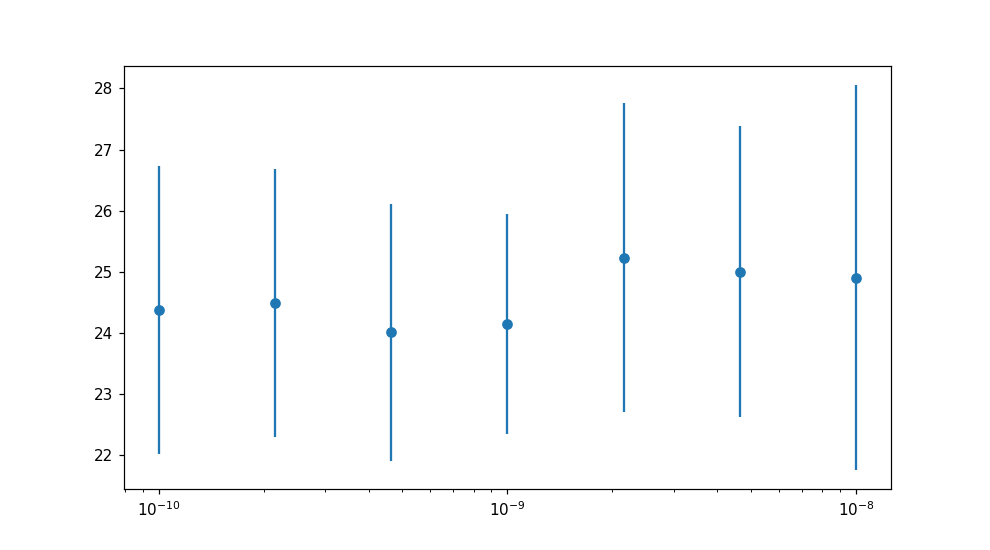

In [56]:
plt.figure()
plt.errorbar(
    mus_to_test, 
    [psnr_gains[0] for psnr_gains in metrics], 
    [psnr_gains[1] for psnr_gains in metrics], 
    linestyle='None', 
    marker='o',
)
plt.axhline(0, color='C3')
plt.xscale('log')